# How large is the influence of the integralization optimization?

It barely has an influence on the solution quality but it improves our lower
bound on the graph instance over 1% for 200 steps. Considering that
the optimality gap is around 10-20%, this closes the optimality gap
by around 5-10%.

In [1]:

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
from _utils import quick_plot_setup

quick_plot_setup(use_tex=False)

In [2]:
data = pd.read_json("./00c_prepared_data.json")
from utils import show_solver_diffs

show_solver_diffs(data)

Solver 0:  integralize=0 with 500 entries
Solver 1:  integralize=10 with 500 entries
Solver 2:  integralize=25 with 500 entries
Solver 3:  integralize=50 with 500 entries
Solver 4:  integralize=100 with 500 entries
Solver 5:  integralize=200 with 500 entries


# Data

* `solution` Solution as json string. Read with `Solution.from_json(data=row["solution"])`.
* `Obj` The objective value computed in the polygon instance.
* `relative_obj` The objective value divided by the minimal objective value for this instance.
* `integralization` The number of integralization steps.
* `instance`, `instance_path` the instance, path to the instance file.
* `grid_lb` the value of the fractional solution.
* `grid_obj` the objective of the solution in the grid (the coverage value can differ from the polygon objective `Obj`)

In [4]:
relaxation = data[data["integralization"] == 0][["instance", "grid_lb"]]
relaxation.drop_duplicates(["instance"], inplace=True)
relaxation.rename(columns={"grid_lb": "relaxation"}, inplace=True)
data = data.merge(right=relaxation, left_on="instance", right_on="instance")

In [5]:
data["relaxation_improvement"] = (data["grid_lb"] / data["relaxation"] - 1) * 100

## How much does the value of the relaxation increase by integralization steps?

Every percent decreases the integrality gap. Higher is better.

It shows a postive effect here. Unfortunately, it does not carry over
to the actual solutions. It primarily improves our lower bound but not
our upper bound (see next plot).

We have a logarithmic improvement of the relaxation.
This was to be expected due to the branch and bound tree.

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


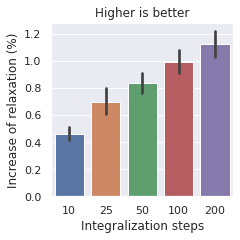

In [6]:
plt.figure(figsize=(3.5, 3.5))
plt.title("Higher is better")
sns.barplot(
    data=data[data["integralization"] != 0],
    x="integralization",
    y="relaxation_improvement",
)
plt.ylabel("Increase of relaxation (%)")
plt.xlabel("Integralization steps")
plt.tight_layout()
plt.savefig("./01c_relaxation_improvement.pdf")
plt.show()

## By how much percent does the objective get improved?

Unfortunately, barely.


### In the graph objectivve

In [7]:
grid_solution_without = data[data["integralization"] == 0][["instance", "grid_obj"]]
grid_solution_without.rename(columns={"grid_obj": "grid_obj_without"}, inplace=True)
data = data.merge(right=grid_solution_without, left_on="instance", right_on="instance")
data["graph_obj_reduction"] = 100 * (data["grid_obj"] / data["grid_obj_without"] - 1)

In [8]:
data.groupby("integralization")["graph_obj_reduction"].mean()

integralization
0      0.000000
10     0.001271
25     0.114917
50    -0.011665
100   -0.003516
200    0.076452
Name: graph_obj_reduction, dtype: float64

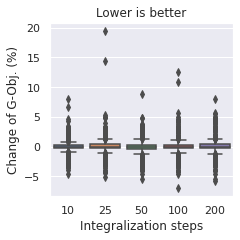

In [9]:
plt.figure(figsize=(3.5, 3.5))
plt.title("Lower is better")
sns.boxplot(
    data=data[data["integralization"] != 0],
    x="integralization",
    y="graph_obj_reduction",
)
plt.ylabel("Change of G-Obj. (%)")
plt.xlabel("Integralization steps")
plt.tight_layout()
plt.savefig("01c_change_of_gobj.pdf")
plt.show()

In [10]:
data["gopt_gap"] = (data["grid_obj"] / data["grid_lb"] - 1) * 100

Warning! The following plot only shows an improvement because
the lower bound is better. Not because the upper bound is better.

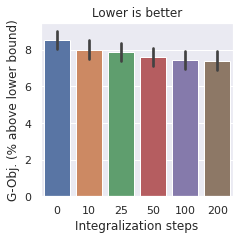

In [11]:
plt.figure(figsize=(3.5, 3.5))
plt.title("Lower is better")
sns.barplot(data=data, x="integralization", y="gopt_gap")
plt.ylabel("G-Obj. (% above lower bound)")
plt.xlabel("Integralization steps")
plt.tight_layout()
plt.savefig("01b_gobj_above_lb.pdf")
plt.show()

### In the polygon objective

In [12]:
solution_without = data[data["integralization"] == 0][["instance", "Obj"]]
solution_without.rename(columns={"Obj": "obj_without"}, inplace=True)
data = data.merge(right=solution_without, left_on="instance", right_on="instance")
data["obj_reduction"] = 100 * (data["Obj"] / data["obj_without"] - 1)

In [13]:
data.groupby("integralization")["obj_reduction"].mean()

integralization
0      0.000000
10     0.074176
25     0.258684
50     0.172494
100    0.175442
200    0.171547
Name: obj_reduction, dtype: float64

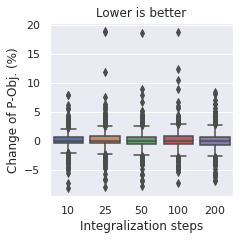

In [14]:
plt.figure(figsize=(3.5, 3.5))
plt.title("Lower is better")
sns.boxplot(
    data=data[data["integralization"] != 0], x="integralization", y="obj_reduction"
)
plt.ylabel("Change of P-Obj. (%)")
plt.xlabel("Integralization steps")
plt.tight_layout()
plt.savefig("01d_change_of_pobj.pdf")
plt.show()

## Old plots

In [15]:
data.sort_values(["solver"], inplace=True, ascending=True)
data.sort_values(["type"], inplace=True, ascending=True, kind="stable")

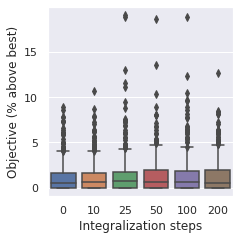

In [16]:
# data = data[data["relative_cost"]<=1000]

plt.figure(figsize=(3.5, 3.5))
sns.boxplot(data=data, x="integralization", y="relative_obj", orient="v")
plt.ylabel("Objective (% above best)")
plt.xlabel("Integralization steps")
plt.tight_layout()
plt.show()

In [17]:
data.groupby(["integralization"])[
    ["relative_obj", "relative_cost", "relative_coverage"]
].mean()

,relative_obj,relative_cost,relative_coverage
integralization,,,
0,1.117292,2.994831,63.661272
10,1.178983,2.918193,63.713251
25,1.366096,2.885762,63.726301
50,1.278631,2.819786,63.696170
100,1.281823,2.868742,63.705354
200,1.276477,3.050116,63.797182


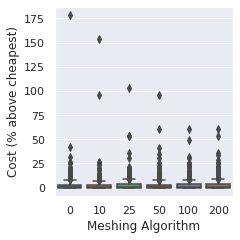

In [18]:
# data = data[data["relative_cost"]<=1000]

plt.figure(figsize=(3.5, 3.5))
sns.boxplot(data=data, x="integralization", y="relative_cost", orient="v")
plt.ylabel("Cost (% above cheapest)")
plt.xlabel("Meshing Algorithm")
plt.tight_layout()
plt.show()

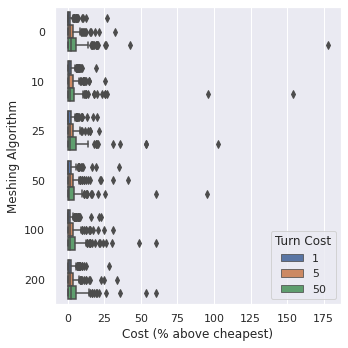

In [19]:
plt.figure(figsize=(5, 5))
sns.boxplot(
    data=data, y="integralization", x="relative_cost", orient="h", hue="turn_factor"
)
plt.xlabel("Cost (% above cheapest)")
plt.ylabel("Meshing Algorithm")
plt.legend(title="Turn Cost")
plt.tight_layout()
plt.show()

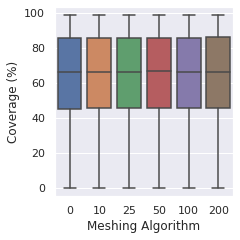

In [20]:
plt.figure(figsize=(3.5, 3.5))
sns.boxplot(data=data, x="integralization", y="relative_coverage", orient="v")
plt.ylabel("Coverage (%)")
plt.xlabel("Meshing Algorithm")

plt.tight_layout()
plt.show()